In [1]:
from openai import OpenAI
from pydantic import BaseModel
from typing import Dict, List,Tuple,Optional
from dotenv import load_dotenv
from utils import *
from chatty_boi import *
import os
from tqdm import tqdm

In [ ]:
node_dict_input = {
    "node_1": (0.00, 0.00),
    "node_2": (6.00,0.00),
    "node_3": (2.00, 0.00),
}
# example_members_input = {
#     "member_1": ("node_1", "node_3", "area_id") #All important calculation and reasoning.
# }

area_id = {
        "0": 1,
        "1": 0.195,
        "2": 0.782,
        "3": 1.759,
        "4": 3.128,
        "5": 4.887,
        "6": 7.037,
        "7": 9.578,
        "8": 12.511,
        "9": 15.834,
        "10": 19.548,
    }

load = {
    "node_3": (-10.00,-45.00),
}
supports = {
    "node_1": "pinned",
    "node_2": "roller",
}

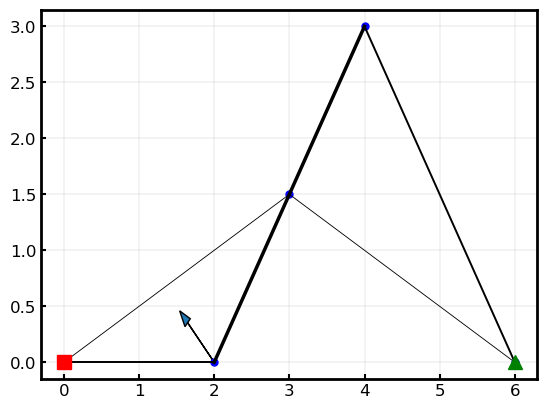

Max stress:  7.83
Total mass:  28.1455
Member mass:  {'member_1': 3.518, 'member_2': 11.2782, 'member_3': 6.3422, 'member_4': 2.6229, 'member_5': 1.4098, 'member_6': 0.3515, 'member_7': 2.6229}
Member stress:  {'member_1': -5.922, 'member_2': -1.9573, 'member_3': 0.0, 'member_4': 1.052, 'member_5': 3.9146, 'member_6': -7.8292, 'member_7': 0.0}


In [ ]:
# initial structure
with open("./responses/q1p1_s15W30_gpt_t1/run_7/_step_7_0.txt", "r") as f:
    initial_structure = f.read()

parsed = ast.literal_eval(initial_structure)
parsed_output = TrussOutput.model_validate(parsed)
node_dict_g = parsed_output.node_dict
member_dict_g = parsed_output.member_dict
gen_1 = make_truss(node_dict_g, member_dict_g, load, supports)
plot_truss(gen_1)
res, result_dict = make_result_dict(gen_1.member_stress(), gen_1.structure_mass())

In [4]:
print(node_dict_g)
print(member_dict_g)
node_dict_input = {
    "node_1": (0.00, 0.00),
    "node_2": (6.00,0.00),
    "node_3": (2.00, 0.00),
}

{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], 'node_3': [2.0, 0.0], 'node_4': [4.0, 3.0], 'node_5': [3.0, 1.5]}
{'member_1': ['node_1', 'node_3', '3'], 'member_2': ['node_3', 'node_4', '4'], 'member_3': ['node_4', 'node_2', '3'], 'member_4': ['node_1', 'node_5', '2'], 'member_5': ['node_5', 'node_4', '2'], 'member_6': ['node_3', 'node_5', '1'], 'member_7': ['node_5', 'node_2', '2']}


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from truss_y import Truss
from utils import plot_truss
from scipy.optimize import linprog, minimize
import itertools

def ground_structure_optimization(node_dict, load, supports, area_dict, max_stress=15, max_weight=30, max_iterations=5):
    """
    Implement ground structure optimization using the truss_y class with area selection from area_dict.
    
    Parameters:
    -----------
    node_dict: dict
        Dictionary of node coordinates {node_label: [x, y]}
    load: dict
        Dictionary of loads {node_label: (magnitude, direction)}
    supports: dict
        Dictionary of support conditions {node_label: support_type}
    area_dict: dict
        Dictionary of available cross-sectional areas {area_id: area_value}
    max_stress: float
        Maximum allowable stress
    max_weight: float
        Maximum allowable weight
    max_iterations: int
        Maximum number of iterations for the optimization process
        
    Returns:
    --------
    optimized_truss: Truss
        The optimized truss structure
    selected_areas: dict
        Selected area_ids for each member
    """
    # Initialize the truss with nodes
    truss = Truss()
    for node, coords in node_dict.items():
        truss.add_node(node, coords[0], coords[1])
    
    # Generate all possible members (ground structure)
    nodes = list(node_dict.keys())
    members = {}
    member_index = 0
    
    # Create all possible connections between nodes
    for i, j in itertools.combinations(range(len(nodes)), 2):
        node_i = nodes[i]
        node_j = nodes[j]
        member_label = f"member_{member_index+1}"
        # Start with area_id = "1" as default
        members[member_label] = [node_i, node_j, "1"]
        member_index += 1
    
    # Apply loads and supports
    for node, (magnitude, direction) in load.items():
        truss.apply_load(node, magnitude, direction)
    
    for node, support_type in supports.items():
        truss.apply_support(node, type=support_type)
    
    # Add all members to the truss
    for member_label, (start_node, end_node, area_id) in members.items():
        try:
            truss.add_member(member_label, start_node, end_node, area_id)
        except ValueError:
            # Skip if member already exists
            continue
    
    # Analyze initial truss
    print(f"Initial truss with {len(truss.members)} members")
    
    # Set up for optimization
    all_members = list(truss.members.keys())
    num_members = len(all_members)
    area_ids = list(area_dict.keys())
    
    # Function to build a truss with given area IDs
    def build_truss_with_areas(area_id_selections):
        test_truss = Truss()
        
        # Add nodes
        for node, coords in node_dict.items():
            test_truss.add_node(node, coords[0], coords[1])
        
        # Add loads and supports
        for node, (magnitude, direction) in load.items():
            test_truss.apply_load(node, magnitude, direction)
        
        for node, support_type in supports.items():
            test_truss.apply_support(node, type=support_type)
        
        # Add members with selected areas
        for i, member in enumerate(all_members):
            start_node, end_node = truss.members[member]
            selected_id = area_ids[int(area_id_selections[i])]
            test_truss.add_member(member, start_node, end_node, selected_id)
        
        return test_truss
    
    # Function to evaluate the objective and constraints
    def evaluate_truss(area_id_selections):
        # Round to nearest integer to select valid area ID indices
        area_id_indices = np.round(area_id_selections).astype(int)
        area_id_indices = np.clip(area_id_indices, 0, len(area_ids) - 1)
        
        # Build truss with selected areas
        test_truss = build_truss_with_areas(area_id_indices)
        
        try:
            # Calculate stresses
            stresses = test_truss.member_stress()
            abs_stresses = {m: abs(s) for m, s in stresses.items()}
            max_abs_stress = max(abs_stresses.values())
            
            # Calculate weight
            weight = test_truss.structure_mass()[0]
            
            # Objective: minimize maximum stress
            objective = max_abs_stress
            
            # Store for constraints
            result = {
                'truss': test_truss,
                'stresses': abs_stresses,
                'max_stress': max_abs_stress,
                'weight': weight,
                'area_selections': {member: area_ids[area_id_indices[i]] for i, member in enumerate(all_members)}
            }
            
            evaluate_truss.last_result = result
            
            # If constraints are violated, penalize the objective
            if max_abs_stress > max_stress:
                objective += 1000 * (max_abs_stress - max_stress)
            
            if weight > max_weight:
                objective += 1000 * (weight - max_weight)
                
            return objective
            
        except Exception as e:
            print(f"Error in analysis: {e}")
            evaluate_truss.last_result = None
            return 1e6  # High value for failed analysis
    
    # Initialize for storing the last evaluation result
    evaluate_truss.last_result = None
    
    # Initial design: all members with area_id = "1"
    initial_design = np.zeros(num_members)
    print(f"Starting optimization with {num_members} members...")
    
    # Bounds ensure we stay within the valid area_id indices
    bounds = [(0, len(area_ids) - 1) for _ in range(num_members)]
    
    # Minimize using a global optimization method
    for iteration in range(max_iterations):
        print(f"Iteration {iteration+1}/{max_iterations}")
        
        # Use differential evolution for better global search
        result = minimize(
            evaluate_truss, 
            initial_design,
            method='Nelder-Mead',  # Or try 'SLSQP', 'Nelder-Mead', etc.
            bounds=bounds,
            options={'maxiter': 100, 'disp': True}
        )
        
        if not result.success:
            print(f"Optimization warning: {result.message}")
        
        print(f"Optimization function value: {result.fun}")
        
        # Get the last evaluated result
        if evaluate_truss.last_result is None:
            print("No valid solution found")
            break
            
        last_result = evaluate_truss.last_result
        print(f"Maximum stress: {last_result['max_stress']}")
        print(f"Total weight: {last_result['weight']}")
        
        # Extract results
        optimized_truss = last_result['truss']
        selected_areas = last_result['area_selections']
        
        # Print selected area IDs
        print("Selected area IDs:")
        for member, area_id in selected_areas.items():
            print(f"{member}: {area_id} (area = {area_dict[area_id]})")
        
        # For visualization, update the truss with actual areas
        for member, area_id in selected_areas.items():
            optimized_truss._area[member] = area_dict[area_id]
        
        # Check if constraints are met
        if last_result['max_stress'] <= max_stress and last_result['weight'] <= max_weight:
            print("Constraints satisfied!")
            break
        
        # Update initial design for next iteration
        area_id_indices = np.array([area_ids.index(selected_areas[m]) for m in all_members])
        initial_design = area_id_indices
    
    return optimized_truss, selected_areas

# Example usage with the provided inputs


In [6]:
import numpy as np
import random
from scipy.spatial import Delaunay
from itertools import combinations

def generate_nodes_and_delaunay_members(node_dict, max_nodes, area_ids, spacing=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Step 1: Get existing node info
    current_count = len(node_dict)
    if current_count >= max_nodes:
        raise ValueError("Initial node count already exceeds or equals max_nodes.")

    node_labels = list(node_dict.keys())
    existing_coords = list(node_dict.values())

    # Step 2: Set fixed y-range to force 2D spread
    all_x = [coord[0] for coord in existing_coords]
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = 0, 10  # force vertical spread regardless of existing y values

    # Step 3: Generate candidate grid
    grid_x = np.arange(x_min, x_max + spacing, spacing)
    grid_y = np.arange(y_min, y_max + spacing, spacing)
    grid_set = set(existing_coords)  # fast lookup
    candidate_points = [(x, y) for x in grid_x for y in grid_y if (x, y) not in grid_set]

    random.shuffle(candidate_points)
    new_points = candidate_points[:(max_nodes - current_count)]

    # Step 4: Add new nodes
    next_index = current_count + 1
    for x, y in new_points:
        label = f"node_{next_index}"
        node_dict[label] = (x, y)
        next_index += 1

    # Step 5: Delaunay triangulation with jitter to avoid coplanarity
    all_points = np.array(list(node_dict.values()))
    all_labels = list(node_dict.keys())
    tri = Delaunay(all_points, qhull_options="QJ")

    # Step 6: Get all unique edge pairs (denser: includes diagonals)
    edges = set()
    for simplex in tri.simplices:
        for a, b in combinations(simplex, 2):
            edges.add(tuple(sorted((a, b))))

    # Step 7: Build member dict with area ID
    member_dict = {}
    for i, (a, b) in enumerate(edges):
        node_a = all_labels[a]
        node_b = all_labels[b]
        area_id = str(random.choice(list(area_ids.keys())))
        member_dict[f"member_{i}"] = [node_a, node_b, area_id]

    return node_dict, member_dict


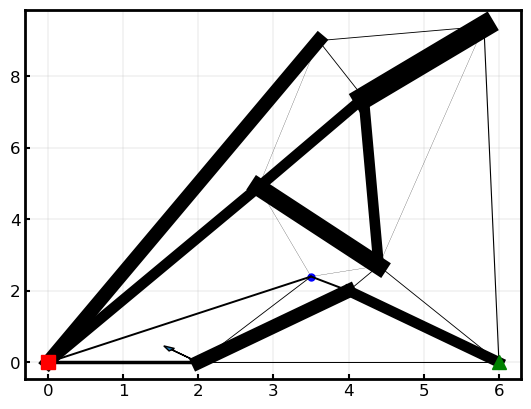

Max stress:  9.72
Total mass:  446.7386
Member mass:  {'member_0': 0.8146, 'member_1': 1.7486, 'member_2': 27.4439, 'member_3': 6.256, 'member_4': 7.4649, 'member_5': 2.4543, 'member_6': 2.2132, 'member_7': 9.4021, 'member_8': 35.3865, 'member_9': 0.6305, 'member_10': 0.185, 'member_11': 43.0731, 'member_12': 4.692, 'member_13': 3.128, 'member_14': 121.2728, 'member_15': 27.0907, 'member_16': 50.0673, 'member_17': 45.0573, 'member_18': 1.3363, 'member_19': 0.5062, 'member_20': 1.1263, 'member_21': 54.0542, 'member_22': 1.3347}
Member stress:  {'member_0': 1.3688, 'member_1': 1.3988, 'member_2': -0.1107, 'member_3': -3.8917, 'member_4': 3.9612, 'member_5': 1.1748, 'member_6': -7.0181, 'member_7': 1.4242, 'member_8': -0.2732, 'member_9': -4.3688, 'member_10': 9.7245, 'member_11': 0.0371, 'member_12': -1.1065, 'member_13': 0.2861, 'member_14': 0.1111, 'member_15': 0.0211, 'member_16': -0.0784, 'member_17': -0.1702, 'member_18': -1.8532, 'member_19': -3.3076, 'member_20': 0.6298, 'member_2

In [7]:
node_dict_, member_dict_ = generate_nodes_and_delaunay_members(
    node_dict=node_dict_input,
    max_nodes=10,
    area_ids=area_id,
    spacing=0.1,
    
)

t_init = make_truss(node_dict_, member_dict_, load, supports)
plot_truss(t_init)
res, result_dict = make_result_dict(t_init.member_stress(), t_init.structure_mass())

In [ ]:
if __name__ == "__main__":


    # Area dictionary
    area_dict = {
        "0": 1,
        "1": 0.195,
        "2": 0.782,
        "3": 1.759,
        "4": 3.128,
        "5": 4.887,
        "6": 7.037,
        "7": 9.578,
        "8": 12.511,
        "9": 15.834,
        "10": 19.548,
    }
    
    # Run the optimization
    optimized_truss, selected_areas = ground_structure_optimization(
        node_dict_, 
        load, 
        supports,
        area_dict,
        max_stress=15,
        max_weight=30,
        max_iterations=20
    )
    
    # Plot the optimized truss
    print("\nFinal result:")
    print("Selected area IDs:")
    for member, area_id in selected_areas.items():
        print(f"{member}: {area_id} (area = {area_dict[area_id]})")
    
    # Plot the final optimized truss
    plot_truss(optimized_truss)
    
    # Calculate and report final maximum stress and weight
    stresses = optimized_truss.member_stress()
    abs_stresses = {m: abs(s) for m, s in stresses.items()}
    max_stress = max(abs_stresses.values())
    total_weight = optimized_truss.structure_mass()[0]
    
    print(f"\nFinal maximum stress: {max_stress}")
    print(f"Final total weight: {total_weight}")

Initial truss with 45 members
Starting optimization with 45 members...
Iteration 1/20
